In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Step 1: Load Data
trade_df = pd.read_csv(r"C:\Users\ASUS\Downloads\historical_data.csv")
sentiment_df = pd.read_csv(r"C:\Users\ASUS\Downloads\fear_greed_index.csv")
print(trade_df.sample(5))
sentiment_df.head()



                                           Account  Coin  Execution Price  \
185899  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  HYPE         13.12900   
203644  0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3   ENA          0.82728   
102827  0x8477e447846c758f5a675856001ea72298fd9cb5   ZRO          5.11000   
48605   0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  HYPE         24.63700   
175419  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  HYPE         16.07900   

        Size Tokens  Size USD  Side     Timestamp IST  Start Position  \
185899         5.96     78.25   BUY  26-03-2025 20:28          -29.43   
203644      1209.00   1000.18   BUY  20-01-2025 06:38      -412031.00   
102827        48.90    249.88   BUY  21-07-2024 00:46       -26641.30   
48605          0.45     11.09   BUY  06-02-2025 04:20        -9735.67   
175419        31.09    499.90  SELL  04-03-2025 16:07        19183.53   

          Direction  Closed PnL  \
185899  Close Short    2.482340   
203644  Close Short  262.575

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [17]:
# Step 2: Preprocess Time Columns
trade_df['datetime'] = pd.to_datetime(trade_df['Timestamp'], unit='ms')## 13 digit number in unix format.
sentiment_df['datetime'] = pd.to_datetime(sentiment_df['timestamp'], unit='s')## 10 digit number in unix format.
print("trade data is",trade_df.head())
print("sentiment data is",sentiment_df.head())

trade data is                                       Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0        

In [18]:
# Step 3: Sort and Merge on Nearest Timestamp
trade_df = trade_df.sort_values('datetime')
sentiment_df = sentiment_df.sort_values('datetime')
print(trade_df.head())


merged_df = pd.merge_asof(trade_df, sentiment_df[['datetime', 'value', 'classification']], on='datetime')

print(merged_df.head())

                                          Account  Coin  Execution Price  \
83771  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891   ETH       1898.60000   
83770  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891   ETH       1897.90000   
83769  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891   ETH       1897.90000   
39280  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23   SEI          0.44868   
39641  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  NTRN          1.46680   

       Size Tokens  Size USD  Side     Timestamp IST  Start Position  \
83771       0.0722    137.08   BUY  01-05-2023 01:06          0.1791   
83770       0.0824    156.39   BUY  01-05-2023 01:06          0.0967   
83769       0.0967    183.53   BUY  01-05-2023 01:06          0.0000   
39280   15078.0000   6765.20  SELL  28-12-2023 06:52      37599.0000   
39641    3348.0000   4910.85  SELL  07-01-2024 06:27      14206.0000   

        Direction  Closed PnL  \
83771   Open Long    0.000000   
83770   Open Long    0.000000   
83769   Ope

In [19]:
# Step 4: Feature Engineering
merged_df['Aggressive'] = merged_df['Crossed'].astype(str).str.upper() == "TRUE"
merged_df['Fee Ratio'] = merged_df['Fee'] / merged_df['Size USD']
merged_df['Win'] = merged_df['Closed PnL'] > 0

In [20]:
# Step 5: Aggregate Trader-Level Metrics
trader_summary = merged_df.groupby('Account').agg({
    'Execution Price': 'mean',
    'Size USD': 'mean',
    'Fee Ratio': 'mean',
    'Aggressive': 'mean',
    
    'value': 'mean',
    'Win': 'mean',
    'Trade ID': 'count'
}).rename(columns={
    'Execution Price': 'Avg Price',
    'Size USD': 'Avg Size USD',
    'Fee Ratio': 'Avg Fee %',
    'Aggressive': 'Aggression Rate',
    
    'value': 'Avg Sentiment',
    'Win': 'Win Rate',
    'Trade ID': 'Trade Count'
}).reset_index()

print(trader_summary.head())

                                      Account     Avg Price  Avg Size USD  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012   2065.999872  16159.576734   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd    265.622352   1653.226327   
2  0x271b280974205ca63b716753467d5a371de622ab  15953.138177   8893.000898   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4   6537.333556    507.626933   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd     18.484069   3138.894782   

   Avg Fee %  Aggression Rate  Avg Sentiment  Win Rate  Trade Count  
0   0.000092         0.112101      47.388161  0.359612         3818  
1   0.000226         0.775549      56.057830  0.442720         7280  
2   0.000216         0.654765      60.124705  0.301917         3809  
3   0.000449         0.945459      57.691759  0.438585        13311  
4   0.000289         0.757333      50.631368  0.519914         3239  


In [21]:
#  Sentiment-wise report
print("\nTrade Size by Sentiment Classification:")
print(merged_df.groupby('classification')['Size USD'].mean())

print("\nAggression Rate by Sentiment Classification:")
print(merged_df.groupby('classification')['Aggressive'].mean())

print("\nFee Ratio by Sentiment Classification:")
print(merged_df.groupby('classification')['Fee Ratio'].mean())


Trade Size by Sentiment Classification:
classification
Extreme Greed    5660.265764
Fear             5259.977837
Greed            6731.682923
Neutral          3058.848110
Name: Size USD, dtype: float64

Aggression Rate by Sentiment Classification:
classification
Extreme Greed    0.550129
Fear             0.600675
Greed            0.607968
Neutral          0.799048
Name: Aggressive, dtype: float64

Fee Ratio by Sentiment Classification:
classification
Extreme Greed    0.000183
Fear             0.000221
Greed            0.000241
Neutral          0.003871
Name: Fee Ratio, dtype: float64


SOME VALUABELE INSIGHTS



## Greedy periods → higher aggressiveness, more large trades

## Fearful periods → smaller trade sizes, more fee-efficient

## Trader clusters → identify behavior patterns (e.g. cautious vs. aggressive)

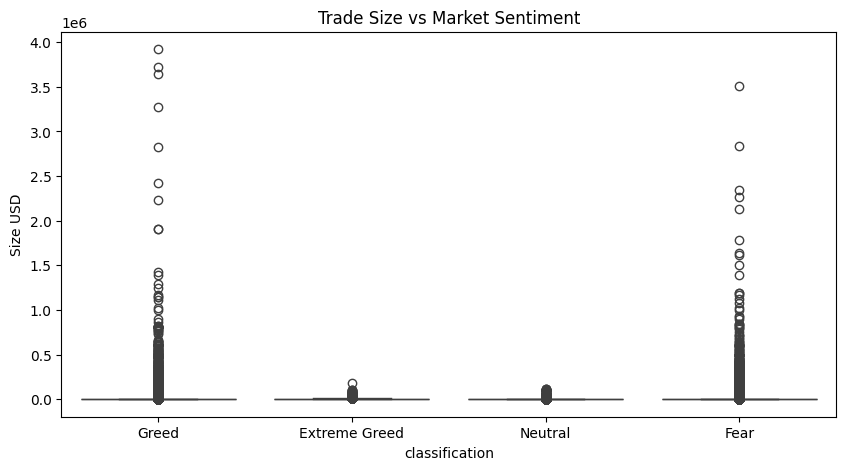

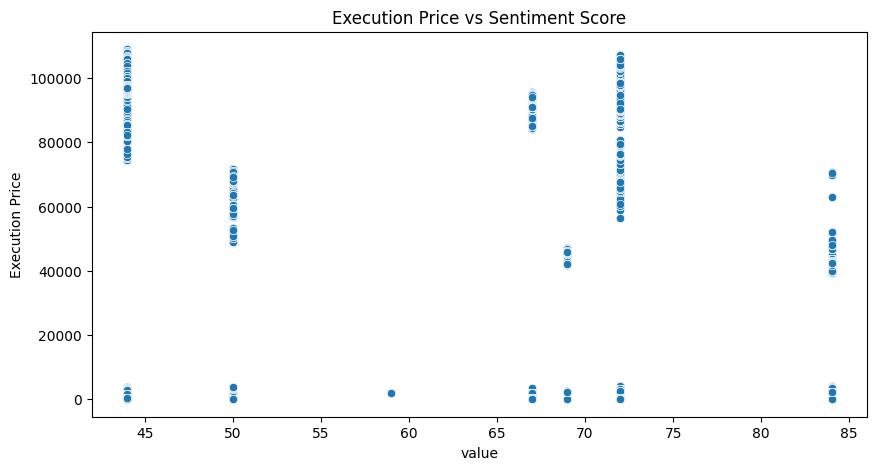

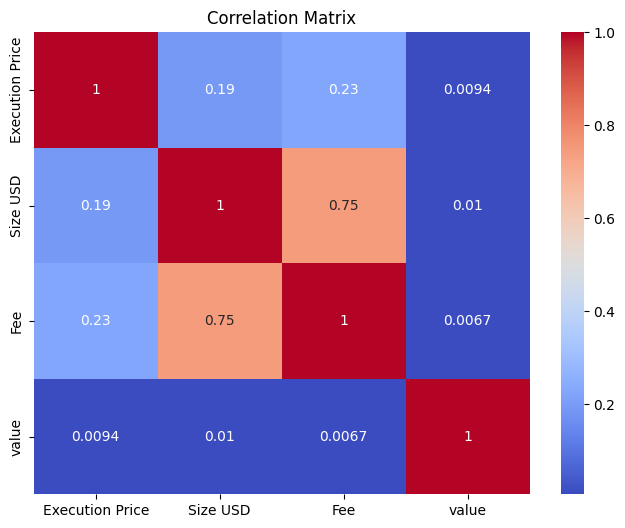

In [22]:
#  Visualizations
plt.figure(figsize=(10, 5))
sns.boxplot(x='classification', y='Size USD', data=merged_df) ## boxplot for outliers
plt.title("Trade Size vs Market Sentiment")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x='value', y='Execution Price', data=merged_df)
plt.title("Execution Price vs Sentiment Score")
plt.show()

# Step 8: Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df[['Execution Price', 'Size USD', 'Fee', 'value']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

